In [ ]:
#yet another new script - this time, now that we have hovmoller plots of frequency and intensity for arbitrary time
#periods, go and calculate their significance

#In the case of frequency changes, we can calculate the change in significance analytically because a binary variable
#obeys a Bernoulli distribution, with variance p*(1-p) and standard error (p*(1-p)/n)^(1/2),

#Another really important factor is that we'll eventually have to calculate the autocorrelation
#in other words, the probability of seeing a rainband on one day is higher than usual if we've just seen one
#this will lower the effective sample size n = N/tau with N as total observations.

In [29]:
import numpy as np
import time
import os
import netCDF4 as nc
import datetime
import matplotlib.pyplot as plt
#import masked arrays - important because intensity shows up as a NaN at some points
%matplotlib notebook
import numpy.ma as ma
import scipy.stats as st

In [3]:
## LOAD FROM NETCDF FILE ##
savefile = "RDA_hov_periods"
ferretpath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
hovname = ferretpath + savefile + ".nc"
hovnc = nc.Dataset(hovname, "r")

#populate lists with intensity occupancy plots for each different time period (periods given below)
p1_beg = [1951,1980]
p1_end = [1979,1993]
p2_beg = [1980,1994]
p2_end = [2007,2007]

#in this case, we're just going to load the smoothed plots of hovmoller frequency
lats_1_p1 = []
lats_p1 = []

lats_1_p2 = []
lats_p2 = []


for p1_b, p1_e, p2_b, p2_e in zip(p1_beg, p1_end, p2_beg, p2_end):

    years_p1= str(p1_b-1900) + str("{0:0=2d}".format((p1_e-1900)%100))
    print(years_p1)
    years_p2= str(p2_b-1900) + str("{0:0=2d}".format((p2_e-1900)%100))
    print(years_p2)
    
    lats_1_p1.append(hovnc['lat_1_hov_smth_' + years_p1][:])
    lats_p1.append(hovnc['lat_hov_smth_' + years_p1][:])
    
    lats_1_p2.append(hovnc['lat_1_hov_smth_' + years_p2][:])
    lats_p2.append(hovnc['lat_hov_smth_' + years_p2][:])
    
hovnc.close()

5179
8007
8093
9407


<IPython.core.display.Javascript object>


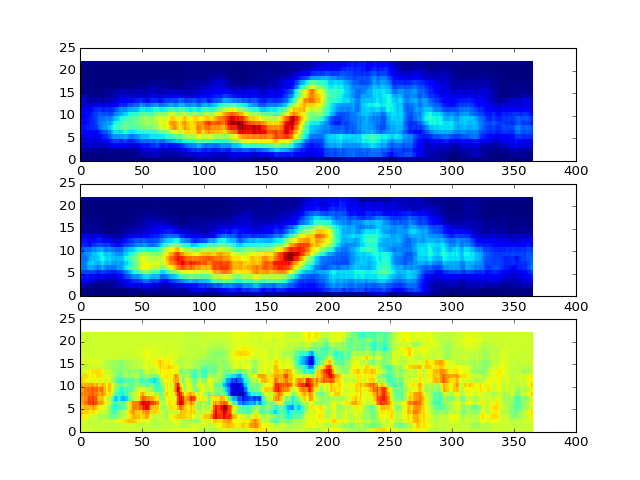

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
plt.pcolormesh(lats_1_p1[0].T)

ax1 = fig.add_subplot(312)
plt.pcolormesh(lats_1_p2[0].T)

ax1 = fig.add_subplot(313)
plt.pcolormesh(lats_1_p2[0].T-lats_1_p1[0].T)

<IPython.core.display.Javascript object>


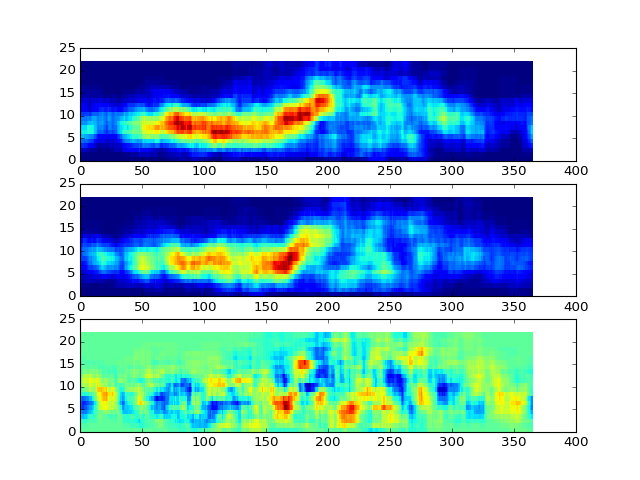

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
plt.pcolormesh(lats_1_p1[1].T)

ax1 = fig.add_subplot(312)
plt.pcolormesh(lats_1_p2[1].T)

ax1 = fig.add_subplot(313)
plt.pcolormesh(lats_1_p2[1].T-lats_1_p1[1].T)

In [5]:
#returns the standard error for a Bernoulli variable with probability of success p and number
#of trials n.
def bernoulli_std(p, n):
    s = (p*(1-p)/n)**.5
    return s

#performs bernoulli_std for each point in 2D numpy array F, returns array of standard deviations
#F is a probability distributed between 0 and 1.
def freq_std(F, years, dayrange, latrange):
    S = np.zeros(F.shape)
    ll = (latrange-1)/2
    
    for i in range(S.shape[0]):
        for j in range(S.shape[1]):
            
            #have to adjust number of samples if we're at the edges
            lrange = int(min(S.shape[1]-1,j+ll) - max(0,j-ll) + 1)
            nn = years*dayrange*lrange
            S[i,j] = bernoulli_std(F[i,j],nn)
    
    return S

In [6]:
#find standard deviation for each day and bin
lats_1_p1_std = [ freq_std(x, 57, 15, 5) for x in lats_1_p1 ]
lats_p1_std = [ freq_std(x, 57, 15, 5) for x in lats_p1 ]

lats_1_p2_std = [ freq_std(x, 57, 15, 5) for x in lats_1_p2 ]
lats_p2_std = [ freq_std(x, 57, 15, 5) for x in lats_p2 ]

<IPython.core.display.Javascript object>


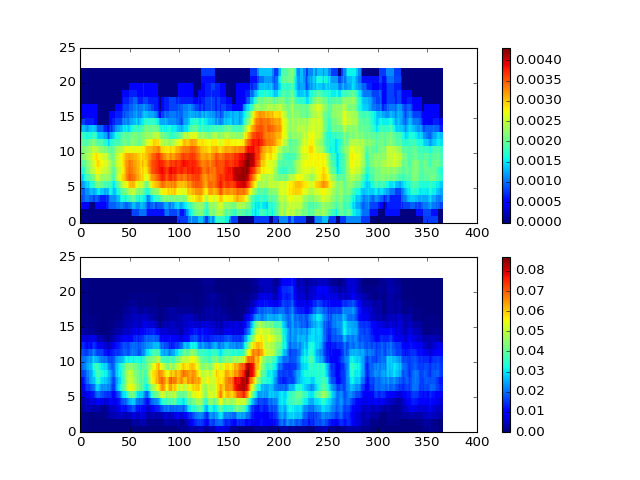

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
plt.pcolormesh(lats_1_p2_std[1].T)
plt.colorbar()

ax2 = fig.add_subplot(212)
plt.pcolormesh(lats_1_p2[1].T)
plt.colorbar()


In [14]:
lats_1_p2_std[0][0,:]

array([ 0.        ,  0.00041706,  0.00094219,  0.00148545,  0.00169123,
        0.00193027,  0.00216603,  0.00211608,  0.00203868,  0.00203868,
        0.00190213,  0.00159182,  0.00144819,  0.0010529 ,  0.00066687,
        0.00033367,  0.00033367,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [9]:
bernoulli_std(.7, 57*15*3)

0.009048278567177282

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


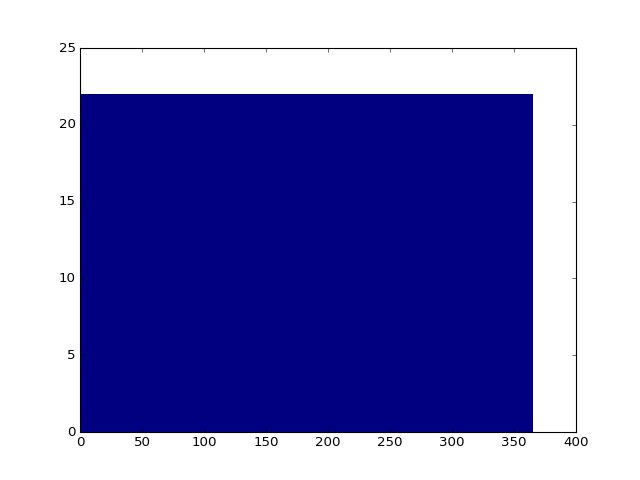

[[        nan  0.03510339  1.26584545 ...,         nan         nan
          nan]
 [        nan  0.03510339  1.36036309 ...,         nan         nan
          nan]
 [        nan  0.03510339  0.90258053 ...,         nan         nan
          nan]
 ..., 
 [        nan  0.03510339  0.48217961 ...,         nan         nan
          nan]
 [        nan  0.03510339  0.90258053 ...,         nan         nan
          nan]
 [        nan  0.03510339  0.90258053 ...,         nan         nan
          nan]]


In [43]:
Zscore = (lats_p2[0]-lats_p1[0])/((lats_p1_std[0]**2+lats_p2_std[0]**2)**.5)
fig,ax = plt.subplots()
plt.pcolormesh(Zscore.T)

print(Zscore)

In [35]:
## CALCULATE CHANGES IN FREQUENCY BETWEEN TIME PERIODS
lats_1_diff = []
lats_diff = []

lats_1_Z = []
lats_Z = []

for lat_p1, lat_p1_std, lat_p2, lat_p2_std in zip(lats_1_p1, lats_1_p1_std, lats_1_p2, lats_1_p2_std):
    
    lats_1_diff.append(lat_p2-lat_p1)
    Zscore = (lat_p2-lat_p1)/((lat_p1_std**2+lat_p2_std**2)**.5)
    lats_1_Z.append(ma.array(Zscore, mask = np.isnan(Zscore))
    
for lat_p1, lat_p1_std, lat_p2, lat_p2_std in zip(lats_p1, lats_p1_std, lats_p2, lats_p2_std):
    
    lats_diff.append(lat_p2-lat_p1)
    Zscore = (lat_p2-lat_p1)/((lat_p1_std**2+lat_p2_std**2)**.5)
    lats_Z.append(ma.array(Zscore, mask = np.isnan(Zscore))


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1665: RuntimeWarning: invalid value encountered in greater
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1665: RuntimeWarning: invalid value encountered in less
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1666: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


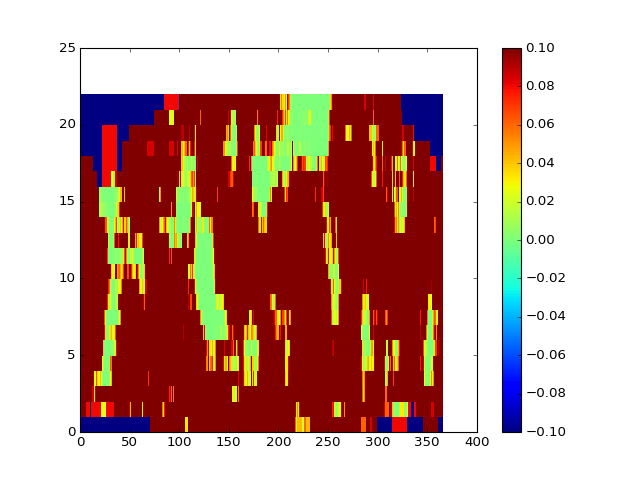

In [36]:
fig,ax = plt.subplots()
plt.pcolormesh(lats_pval[0].T)
plt.colorbar()


In [7]:
qq = freq_std(lats_1_p1[0],57,15,5)

In [38]:
st.norm.cdf(2)

0.97724986805182079